In [1]:
import numpy as np
from datetime import datetime
import pandas as pd
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import h5py
from torch.utils.data.dataset import Dataset
from sklearn.metrics import balanced_accuracy_score

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os,sys
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
torch.cuda.is_available()

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2


True

In [3]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class, in_channels,dropout=0.2):
        super().__init__()
                
        self.dconv_down1 = double_conv(in_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.dconv_down5 = double_conv(512, 1024)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up4 = double_conv(512 + 1024, 512)
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, in_channels, 1)
        self.fc1 = nn.Linear(25600 ,1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(dropout)
        self.out = nn.Linear(1024, n_class)
        self.relu = nn.ReLU()
#         self.init_weights()
        
#     def init_weights(self):
#         self.dconv_down1.weight.data.normal_(0, 0.01)
#         self.dconv_down2.weight.data.normal_(0, 0.01)
#         self.dconv_down3.weight.data.normal_(0, 0.01)
#         self.dconv_down4.weight.data.normal_(0, 0.01)
#         self.dconv_up3.weight.data.normal_(0, 0.01)
#         self.dconv_up2.weight.data.normal_(0, 0.01)
#         self.dconv_up1.weight.data.normal_(0, 0.01)
#         self.conv_last.weight.data.normal_(0, 0.01)
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4) 
    
        x = self.dconv_down5(x) 
        
        #Classifier
        flatten = x.view(x.size(0),-1)
#         print('fc:',flatten.size())
        y = self.fc1(flatten)
        y = self.bn_fc1(y)
        y = self.relu(y)
        y = self.dropout1(y)

        y = self.out(y)
#         print('out:',x.size())
        prediction = nn.functional.log_softmax(y,dim=1)
        
        x = self.upsample(x)
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv_up4(x)
        
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)
        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        out = self.relu(out)
        return out,prediction

In [4]:
def init_weights(m):
# print(m)
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        m.weight.data.normal_(0, 0.0001)
# print(m.weight)

# net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
# net.apply(init_weights)

In [5]:
from collections import defaultdict
import torch.nn.functional as F

In [6]:
def calc_loss(out, prediction, target, original, metrics, MSE_weight=0.5):
    CE = F.cross_entropy(prediction, target)
#     BCE = F.binary_cross_entropy_with_logits(prediction, target)
#     out = torch.sigmoid(out)
    MSE = F.mse_loss(out*65535, original*65535)
    
    loss = MSE * MSE_weight + CE * (1 - MSE_weight)
#     loss = MSE * MSE_weight + CE
    
    metrics['CE'] += CE.data.cpu().numpy() * target.size(0)
    metrics['MSE'] += MSE.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))   

In [7]:
def train_model(model, dataloaders, optimizer1, optimizer2, scheduler1, scheduler2, num_epochs=25):
    start = datetime.now()
    val_acc_history = []
    train_acc_history = []
    val_Bacc_history = []
    train_Bacc_history = []
    val_loss_history = []
    train_loss_history = []
    val_MSEloss_history = []
    lr_history = []
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            LabelList = torch.tensor([1]).to(device)
            PredList = torch.tensor([1]).to(device)
            if phase == 'train':
                if epoch < 5:
                    for param_group in optimizer1.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                else:
                    for param_group in optimizer2.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
#             running_loss = 0.0
            running_corrects = 0
            confusion_matrix = torch.zeros(3, 3)
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                if epoch < 5:
                    optimizer1.zero_grad()
                else:
                    optimizer2.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs,predictions = model(inputs)
                    loss = calc_loss(outputs, predictions,labels,inputs, metrics,MSE_weight = 1e-8)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        if epoch < 5:
                            optimizer1.step()
                        else:
                            optimizer2.step()
                _, preds = torch.max(predictions, 1)
                # statistics
                epoch_samples += inputs.size(0)
                LabelList = torch.cat([LabelList,labels.view(-1)],dim=0)
                PredList = torch.cat([PredList, preds.view(-1)],dim=0)
#                 # statistics
#                 for t, p in zip(labels.view(-1), preds.view(-1)):
#                     confusion_matrix[t.long(), p.long()] += 1
                  
                running_corrects += torch.sum(preds == labels.data)
            
            
#             confusionMat = np.asarray(confusion_matrix)
#             sumconfusion = np.sum(confusionMat,axis = 1).T

#             summat = np.tile(sumconfusion,(3,1)).T
#             # print(test)
#             percentconfusion = np.divide(confusionMat,summat)
            epoch_acc_balanced = balanced_accuracy_score(LabelList[1:].cpu(), PredList[1:].cpu())
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            epoch_acc = running_corrects.double() / epoch_samples
            print('{} Acc: {:.4f}'.format(phase, epoch_acc))
            print('{} Bal. Acc: {:.4f}'.format(phase, epoch_acc_balanced))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print("saving best model")
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_Bacc_history.append(epoch_acc_balanced)
                val_loss_history.append(epoch_loss)
                val_MSEloss_history.append(metrics['MSE']/epoch_samples)
                if epoch < 5:
                    scheduler1.step(epoch_loss)
                elif epoch > num_epochs * (2/3):
                    scheduler2.step(epoch_loss)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_Bacc_history.append(epoch_acc_balanced)
                train_loss_history.append(epoch_loss)
#             if epoch_acc == 1:
#                 break
        
        if epoch > 2 and val_MSEloss_history[-1] > 5e7 :
                break
        print("Total time: %s" %(datetime.now() - start))
        time_elapsed = time.time() - since
        print('Epoch time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best val acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_acc_history,train_loss_history,val_acc_history,val_loss_history,lr_history,train_Bacc_history,val_Bacc_history

In [8]:
DatadirTrain = "H:\\WBCDataset_v4\\3DImagesKFold-aug"
DatadirVal = "H:\\WBCDataset_v4\\3DImagesKFold-aug"

In [9]:
# import os
# import os.path

# for dirpath, dirnames, filenames in os.walk("."):
#     for filename in [f for f in filenames if f.endswith(".log")]:
#         print os.path.join(dirpath, filename)
FoldName = ["Fold-1","Fold-2","Fold-3","Fold-4","Fold-5"]
tempName =FoldName
ValFold = tempName.pop(1)
# FoldName = tempName
print(FoldName)
print(ValFold)
for name in FoldName:
    print(name)

['Fold-1', 'Fold-3', 'Fold-4', 'Fold-5']
Fold-2
Fold-1
Fold-3
Fold-4
Fold-5


In [10]:
import os

def datapreparation(DatadirTrain,DatadirVal,Fold):
    trainpath = []
    FoldName = ["Fold-1","Fold-2","Fold-3","Fold-4","Fold-5"]
    ValFold = FoldName.pop(Fold)
    
    fpath = []
    traindir = DatadirTrain + "\\Gra_Y"
    for name in FoldName:
        trainsubdir = traindir + "\\" + name
        for dirpath, dirnames, filenames in os.walk(trainsubdir):
            for filename in [f for f in filenames if f.endswith(".tif")]:
                tempfpath =os.path.join(dirpath, filename)
                fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Gra train data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])

    fpath = []
    traindir = DatadirTrain + "\\Lym_G"
    for name in FoldName:
        trainsubdir = traindir + "\\" + name
        for dirpath, dirnames, filenames in os.walk(trainsubdir):
            for filename in [f for f in filenames if f.endswith(".tif")]:
                tempfpath =os.path.join(dirpath, filename)
                fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Lym train data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])

    fpath = []
    traindir = DatadirTrain + "\\Mon_U"
    for name in FoldName:
        trainsubdir = traindir + "\\" + name
        for dirpath, dirnames, filenames in os.walk(trainsubdir):
            for filename in [f for f in filenames if f.endswith(".tif")]:
                tempfpath =os.path.join(dirpath, filename)
                fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Mon train data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])

    minitrainpath = []
    minivalpath = []
    valpath = []
    
    fpath = []
    traindir = DatadirVal + "\\Gra_Y"+"\\"+ ValFold
    print(traindir)
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Gra Val data: %d' %(len(train)))
    for i in train:
        valpath.append(fpath[i])
    minitrain, minival = train_test_split(train, test_size=0.2, random_state=3)
    print('Gra mini-train data: %d' %(len(minitrain)))
    print('Gra mini-val data: %d' %(len(minival)))
    for i in minitrain:
        minitrainpath.append(fpath[i])
    for i in minival:
        minivalpath.append(fpath[i])

    fpath = []
    traindir = DatadirVal + "\\Lym_G"+"\\"+ ValFold
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Lym Val data: %d' %(len(train)))
    for i in train:
        valpath.append(fpath[i]) 
    minitrain, minival = train_test_split(train, test_size=0.2, random_state=3)
    print('Lym mini-train data: %d' %(len(minitrain)))
    print('Lym mini-val data: %d' %(len(minival)))
    for i in minitrain:
        minitrainpath.append(fpath[i])
    for i in minival:
        minivalpath.append(fpath[i])

    fpath = []
    traindir = DatadirVal + "\\Mon_U"+"\\"+ ValFold
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Mon Val data: %d' %(len(train)))
    for i in train:
        valpath.append(fpath[i])
    minitrain, minival = train_test_split(train, test_size=0.2, random_state=3)
    print('Mon mini-train data: %d' %(len(minitrain)))
    print('Mon mini-val data: %d' %(len(minival)))
    for i in minitrain:
        minitrainpath.append(fpath[i])
    for i in minival:
        minivalpath.append(fpath[i])
    return trainpath,valpath,minitrainpath,minivalpath

In [11]:
Fold = 0
trainpath,testpath,_,_= datapreparation(DatadirTrain,DatadirVal,Fold)

Gra train data: 10856
Lym train data: 9791
Mon train data: 12153
H:\WBCDataset_v4\3DImagesKFold-aug\Gra_Y\Fold-1
Gra Val data: 2714
Gra mini-train data: 2171
Gra mini-val data: 543
Lym Val data: 2451
Lym mini-train data: 1960
Lym mini-val data: 491
Mon Val data: 3037
Mon mini-train data: 2429
Mon mini-val data: 608


In [12]:
print('train data vol.: ',len(trainpath))
print('test data vol.: ',len(testpath))

train data vol.:  32800
test data vol.:  8202


In [13]:
from skimage import io
import skimage.transform
import scipy
class MyDataset(Dataset):
    def __init__(self, mat_paths, transforms=None):
        self.paths = mat_paths
        self.transforms = transforms
        
    def __getitem__(self, index):
        # Load .mat
#         data = loadmat(self.paths[index])
        data = io.imread(self.paths[index])
#         reshape = skimage.transform.resize(data,(224,224,40))
#         x = torch.from_numpy(reshape.astype(np.float32))
        x = torch.from_numpy(data.astype(np.float32)/65535)
        x = np.transpose(x,(2,0,1))
#         x = np.transpose(np.array(data['Data']),(2,0,1))
        if 'Gra' in self.paths[index]:
            label = int(0)
        elif 'Lym' in self.paths[index]:
            label = int(1)
        elif 'Mon' in self.paths[index]:
            label = int(2)
        if self.transforms:
            x= self.transforms(x)
        return x,label
    
    def __len__(self):
        return len(self.paths)

In [14]:
#actual training
image_datasets = {}
mini_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)
# mini_datasets['train'] = MyDataset(minitrainpath)
# mini_datasets['val'] = MyDataset(minivalpath)
# model testing
# image_datasets['train'] = MyDataset(valpath)
# image_datasets['val'] = MyDataset(testpath)
# test_datasets['val'] = MyDataset(testpath)
print('training data volume: ', image_datasets['train'].__len__())
print('validation data volume: ', image_datasets['val'].__len__())

# print('mini-training data volume: ', mini_datasets['train'].__len__())
# print('mini-validation data volume: ', mini_datasets['val'].__len__())

CellName = ['Granulocyte','Lymphocyte','Monocyte']
image_datasets['train'].__getitem__(0)[0].shape
[ImgTensor,ImgLabel] = image_datasets['train'].__getitem__(0)
print('Cell Label: ',CellName[ImgLabel])
print('image tensor shape: ', ImgTensor.shape)
print('image tensor dtype: ', ImgTensor.dtype)
image_datasets['train'].__getitem__(0)[0]

#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = np.squeeze(ImgTensor.numpy())
print('image shape: ', image.shape)

training data volume:  32800
validation data volume:  8202
Cell Label:  Granulocyte
image tensor shape:  torch.Size([80, 80, 80])
image tensor dtype:  torch.float32
image shape:  (80, 80, 80)


C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


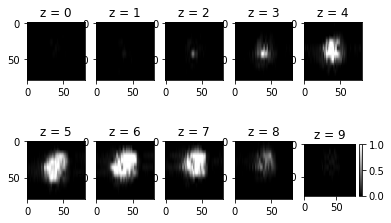

In [15]:
#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = np.transpose(ImgTensor.numpy(), (1,2,0))

def DisplayImage(img,LimMin,LimMax):  
    if img.shape[2]>1:
        for depth in range (0,10):
            plt.subplot(2,5,depth+1)
            plt.imshow(img[:,:,depth*8],vmin=LimMin, vmax=LimMax, cmap ='gray')
            # plt.colorbar()
            plt.title('z = '+ str(depth))
            if depth==9:
                plt.subplot(2,5,depth+1)
                plt.title('z = '+ str(depth))
                ax = plt.gca()
                fig4 = plt.imshow(img[:,:,depth*8],vmin=LimMin, vmax=LimMax, cmap ='gray')

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(fig4, cax=cax)
        plt.show()
    else:
        fig4 = plt.imshow(np.squeeze(img),vmin=LimMin, vmax=LimMax, cmap ='gray')
        plt.title('2D Projection')
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(fig4, cax=cax)
        plt.show()
DisplayImage(image,image.min(),image.max())

In [16]:
print("Initializing Datasets and Dataloaders...")
# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 64
# Create training and validation datasets
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


Fold- 0 : Initializing Datasets and Dataloaders...
Gra train data: 10856
Lym train data: 9791
Mon train data: 12153
H:\WBCDataset_v4\3DImagesKFold-aug\Gra_Y\Fold-1
Gra Val data: 2714
Gra mini-train data: 2171
Gra mini-val data: 543
Lym Val data: 2451
Lym mini-train data: 1960
Lym mini-val data: 491
Mon Val data: 3037
Mon mini-train data: 2429
Mon mini-val data: 608
Epoch 0/99
----------
LR 5e-05
train: CE: 0.624794, MSE: 51820357.280000, loss: 1.142997
train Acc: 0.7294
train Bal. Acc: 0.7359
val: CE: 0.454048, MSE: 44289934.541819, loss: 0.896947
val Acc: 0.8263
val Bal. Acc: 0.8293
saving best model
Total time: 0:12:09.483117
Epoch time: 12m 9s
Epoch 1/99
----------
LR 5e-05
train: CE: 0.417612, MSE: 43787218.337561, loss: 0.855485
train Acc: 0.8380
train Bal. Acc: 0.8366
val: CE: 0.454397, MSE: 42828936.831505, loss: 0.882686
val Acc: 0.8154
val Bal. Acc: 0.8207
Total time: 0:24:26.692049
Epoch time: 12m 17s
Epoch 2/99
----------
LR 5e-05
train: CE: 0.378898, MSE: 42705320.339512, l

val: CE: 0.241977, MSE: 32041450.296025, loss: 0.562391
val Acc: 0.9089
val Bal. Acc: 0.9116
Total time: 5:50:23.182069
Epoch time: 12m 1s
Epoch 29/99
----------
LR 5e-05
train: CE: 0.147614, MSE: 32223379.121951, loss: 0.469848
train Acc: 0.9445
train Bal. Acc: 0.9445
val: CE: 0.265819, MSE: 32073893.076811, loss: 0.586558
val Acc: 0.9058
val Bal. Acc: 0.9070
Total time: 6:02:12.572749
Epoch time: 11m 49s
Epoch 30/99
----------
LR 5e-05
train: CE: 0.143968, MSE: 32185831.758049, loss: 0.465826
train Acc: 0.9453
train Bal. Acc: 0.9453
val: CE: 0.248075, MSE: 31978382.699829, loss: 0.567859
val Acc: 0.9097
val Bal. Acc: 0.9107
Total time: 6:14:00.946121
Epoch time: 11m 48s
Epoch 31/99
----------
LR 5e-05
train: CE: 0.136081, MSE: 32133632.878049, loss: 0.457417
train Acc: 0.9480
train Bal. Acc: 0.9480
val: CE: 0.253576, MSE: 31921499.313338, loss: 0.572791
val Acc: 0.9079
val Bal. Acc: 0.9075
Total time: 6:25:50.082167
Epoch time: 11m 49s
Epoch 32/99
----------
LR 5e-05
train: CE: 0.128

train: CE: 0.019018, MSE: 31102892.296585, loss: 0.330047
train Acc: 0.9931
train Bal. Acc: 0.9932
val: CE: 0.537310, MSE: 30947606.779810, loss: 0.846786
val Acc: 0.8986
val Bal. Acc: 0.8974
Total time: 12:02:01.102924
Epoch time: 11m 45s
Epoch 60/99
----------
LR 5e-05
train: CE: 0.020709, MSE: 31093017.471220, loss: 0.331639
train Acc: 0.9930
train Bal. Acc: 0.9929
val: CE: 0.488598, MSE: 30901883.479639, loss: 0.797617
val Acc: 0.8995
val Bal. Acc: 0.8987
Total time: 12:13:46.261993
Epoch time: 11m 45s
Epoch 61/99
----------
LR 5e-05
train: CE: 0.021386, MSE: 31077064.591220, loss: 0.332157
train Acc: 0.9929
train Bal. Acc: 0.9929
val: CE: 0.533440, MSE: 30927427.627896, loss: 0.842714
val Acc: 0.9049
val Bal. Acc: 0.9051
Total time: 12:25:33.951495
Epoch time: 11m 48s
Epoch 62/99
----------
LR 5e-05
train: CE: 0.015611, MSE: 31063395.808780, loss: 0.326245
train Acc: 0.9945
train Bal. Acc: 0.9946
val: CE: 0.515603, MSE: 30873714.391612, loss: 0.824340
val Acc: 0.9081
val Bal. Acc:

train: CE: 0.000738, MSE: 30812482.909268, loss: 0.308863
train Acc: 0.9999
train Bal. Acc: 0.9999
val: CE: 0.635602, MSE: 30663064.389173, loss: 0.942233
val Acc: 0.9049
val Bal. Acc: 0.9043
Total time: 18:02:09.649564
Epoch time: 11m 48s
Epoch 90/99
----------
LR 1.25e-05
train: CE: 0.001203, MSE: 30809226.528780, loss: 0.309295
train Acc: 0.9998
train Bal. Acc: 0.9998
val: CE: 0.633386, MSE: 30657983.434772, loss: 0.939966
val Acc: 0.9067
val Bal. Acc: 0.9058
Total time: 18:13:58.371616
Epoch time: 11m 49s
Epoch 91/99
----------
LR 1.25e-05
train: CE: 0.000441, MSE: 30802741.412683, loss: 0.308469
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.645060, MSE: 30653162.739332, loss: 0.951591
val Acc: 0.9050
val Bal. Acc: 0.9034
Epoch    24: reducing learning rate of group 0 to 6.2500e-06.
Total time: 18:25:46.891817
Epoch time: 11m 49s
Epoch 92/99
----------
LR 6.25e-06
train: CE: 0.000253, MSE: 30796798.569756, loss: 0.308221
train Acc: 1.0000
train Bal. Acc: 1.0000
val: CE: 0.625

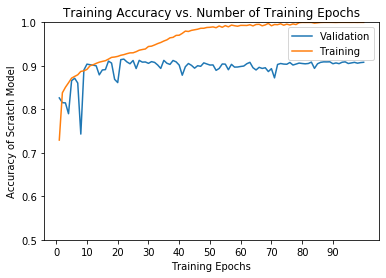

100


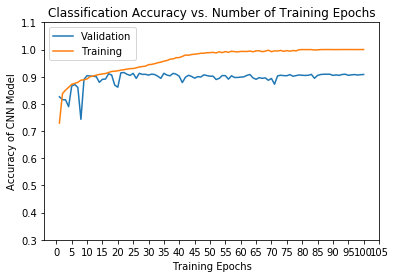

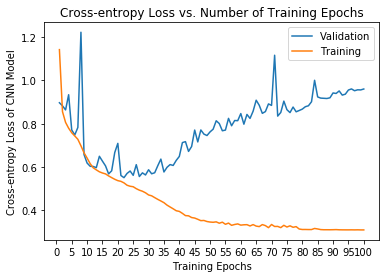

tensor([[2623.,   31.,   60.],
        [  36., 2149.,  266.],
        [  80.,  220., 2737.]])
[2739. 2400. 3063.]
[[0.9664702  0.01142226 0.02210759]
 [0.01468788 0.876785   0.10852713]
 [0.02634178 0.07243991 0.9012183 ]]


C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\11821\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + 

In [17]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

for runs in range (0,1):
    print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
    #Kfold
    Fold = runs
    trainpath,testpath,minitrainpath,minitestpath= datapreparation(DatadirTrain,DatadirVal,Fold)
    image_datasets = {}
    image_datasets['train'] = MyDataset(trainpath)
    image_datasets['val'] = MyDataset(testpath)

    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_class = 3
    in_channel = 80
    num_epochs = 100
    loss_hist_train = []
    while (len(loss_hist_train)<num_epochs/2):
        model = UNet(num_class, in_channel)
        model.apply(init_weights)
        model = model.to(device)

        # freeze backbone layers
        # Comment out to finetune further
        # for l in model.base_layers:
        #     for param in l.parameters():
        #         param.requires_grad = False

        optimizer_ft1 = optim.Adam(model.parameters(), lr=5e-5,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        optimizer_ft2 = optim.Adam(model.parameters(), lr=5e-5,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        # optimizer_ft1 = optim.Adadelta(model.parameters(), lr=1e-3, rho=0.9, eps=1e-06, weight_decay=0)
        # optimizer_ft2 = optim.Adadelta(model.parameters(), lr=1e-3, rho=0.9, eps=1e-06, weight_decay=0)
        # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1) 
        exp_lr_scheduler1 = lr_scheduler.ReduceLROnPlateau(optimizer_ft1, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)
        exp_lr_scheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer_ft2, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)       
        model, scratch_hist_train,loss_hist_train,scratch_hist_val, loss_hist_val,lr_hist,train_Bacc_hist,val_Bacc_hist = train_model(model, dataloaders_dict,optimizer_ft1, optimizer_ft2, exp_lr_scheduler1,exp_lr_scheduler2, num_epochs)
        if len(loss_hist_train)<num_epochs:
            print('model diverges, reinitializing training....\n')
            print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
        
    # num_epochs=15
    fname1 = "training_acc_"+str(runs)+".csv"
    np.savetxt(fname1,scratch_hist_train , delimiter=",")
    fname2 = "validation_acc_"+str(runs)+".csv"
    np.savetxt(fname2,scratch_hist_val , delimiter=",")
    fname13 = "training_Bacc_"+str(runs)+".csv"
    np.savetxt(fname13,train_Bacc_hist, delimiter=",")
    fname23 = "validation_Bacc_"+str(runs)+".csv"
    np.savetxt(fname23,val_Bacc_hist, delimiter=",")
    fname20 = "training_loss_"+str(runs)+".csv"
    np.savetxt(fname20,loss_hist_train , delimiter=",")
    fname21 = "validation_loss_"+str(runs)+".csv"
    np.savetxt(fname21,loss_hist_val , delimiter=",")
    fname22 = "learning_rate_"+str(runs)+".csv"
    np.savetxt(fname22,lr_hist , delimiter=",")
    
    shist = []
    shist1 = []

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Training Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of Scratch Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.5,1.))
    plt.xticks(np.arange(0, num_epochs, 10.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'.png'
    plt.savefig(fname3)
    plt.show()

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Classification Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of CNN Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.3,1.1))
    plt.xticks(np.arange(0, len(shist)+10, 5.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
    plt.savefig(fname3)
    plt.show()

    train_loss = [h for h in loss_hist_train]
    val_loss = [h for h in loss_hist_val]
    plt.title("Cross-entropy Loss vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Cross-entropy Loss of CNN Model")
    plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
    plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
    #     plt.ylim((0.5,1.05))
    plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
    plt.legend()
    fname31 = 'loss_curve_'+str(runs)+'.png'
    plt.savefig(fname31)
    plt.show()

    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
            inputs = inputs.type(torch.FloatTensor)
            inputs = inputs.to(device)
            classes = classes.to(device)
            _, outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    print(confusion_matrix)
    confusionMat = np.asarray(confusion_matrix)
    sumconfusion = np.sum(confusionMat,axis = 0)
    print(sumconfusion)

    import scipy
    sumconfusion = np.sum(confusionMat,axis = 1).T
    # print(np.tile(sumconfusion,(4,1)))
    summat = np.tile(sumconfusion,(3,1)).T
    # print(test)
    percentconfusion = np.divide(confusionMat,summat)
    print(percentconfusion)
    fname4 = "confusion_Mat_UNet_confusionMat_"+str(runs)+".csv"
    np.savetxt(fname4,confusionMat , delimiter=",")
    fname5 = "confusion_Mat_UNet_confusionPer_"+str(runs)+".csv"
    np.savetxt(fname5,percentconfusion , delimiter=",")
    fname6 = 'celltypemodel-unet_2D3D_Run_'+str(runs)+'.pth.tar'

    torch.save(model,fname6)
    print('\n\n')

In [ ]:
fname1 = "training_acc_"+str(runs)+".csv"
np.savetxt(fname1,scratch_hist_train , delimiter=",")
fname2 = "validation_acc_"+str(runs)+".csv"
np.savetxt(fname2,scratch_hist_val , delimiter=",")
fname13 = "training_Bacc_"+str(runs)+".csv"
np.savetxt(fname13,train_Bacc_hist, delimiter=",")
fname23 = "validation_Bacc_"+str(runs)+".csv"
np.savetxt(fname23,val_Bacc_hist, delimiter=",")
fname20 = "training_loss_"+str(runs)+".csv"
np.savetxt(fname20,loss_hist_train , delimiter=",")
fname21 = "validation_loss_"+str(runs)+".csv"
np.savetxt(fname21,loss_hist_val , delimiter=",")
fname22 = "learning_rate_"+str(runs)+".csv"
np.savetxt(fname22,lr_hist , delimiter=",")

shist = []
shist1 = []

shist = scratch_hist_val
shist1 = scratch_hist_train
print(len(shist))
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of Scratch Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.5,1.))
plt.xticks(np.arange(0, num_epochs, 10.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'.png'
plt.savefig(fname3)
plt.show()

shist = [h.cpu().numpy() for h in scratch_hist_val]
shist1 = [h.cpu().numpy() for h in scratch_hist_train]
print(len(shist))
plt.title("Classification Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of CNN Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.3,1.1))
plt.xticks(np.arange(0, len(shist)+10, 5.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
plt.savefig(fname3)
plt.show()

train_loss = [h for h in loss_hist_train]
val_loss = [h for h in loss_hist_val]
plt.title("Cross-entropy Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Cross-entropy Loss of CNN Model")
plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
#     plt.ylim((0.5,1.05))
plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
plt.legend()
fname31 = 'loss_curve_'+str(runs)+'.png'
plt.savefig(fname31)
plt.show()

confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        _, outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
confusionMat = np.asarray(confusion_matrix)
sumconfusion = np.sum(confusionMat,axis = 0)
print(sumconfusion)

import scipy
sumconfusion = np.sum(confusionMat,axis = 1).T
# print(np.tile(sumconfusion,(4,1)))
summat = np.tile(sumconfusion,(3,1)).T
# print(test)
percentconfusion = np.divide(confusionMat,summat)
print(percentconfusion)
fname4 = "confusion_Mat_ResNet_confusionMat_"+str(runs)+".csv"
np.savetxt(fname4,confusionMat , delimiter=",")
fname5 = "confusion_Mat_ResNet_confusionPer_"+str(runs)+".csv"
np.savetxt(fname5,percentconfusion , delimiter=",")
fname6 = 'celltypemodel-ResNet_3D_Run_'+str(runs)+'.pth.tar'

torch.save(model,fname6)
print('\n\n')

In [ ]:
import seaborn as sns
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.1%}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.tile(np.sum(cf,axis = 0),(3,))]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
#         accuracy  = np.trace(cf) / 3
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nBalanced Accuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
CellName = ['HEK293','HELA','MCF7']
categories = CellName
make_confusion_matrix(percentconfusion, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Blues',title = 'ResNet18 - 3D Input')

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model = torch.load('celltypemodel-resnet_80rech_Run_1.pth.tar')
scratch_model_fc = nn.Sequential(*(list(scratch_model.children())[:-1]))
scratch_model_fc = scratch_model_fc.to(device)
scratch_model_fc.eval()

In [ ]:
#testing
image_datasets = {}
test_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)
image_datasets['val'].__getitem__(0)[0].shape

In [ ]:
# Create training and test dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = scratch_model_fc(inputs).cpu().clone().numpy()
        if i == 0:
            outputlist = outputs
            y = classes.cpu().clone().numpy()
        else:
            outputlist = np.append(outputlist,outputs, axis=0)
            y = np.append(y,classes.cpu().clone().numpy(), axis=0)

In [ ]:
print(len(outputlist))
print(outputlist.shape)
print(y.shape)
outputlist = np.squeeze(outputlist)
print(outputlist.shape)

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components=2, random_state=0,verbose=1, perplexity=45, learning_rate=200,early_exaggeration = 40, n_iter=4000)
X_2d = tsne.fit_transform(outputlist)
CellName = ['HEK293','HELA','MCF7']

In [ ]:

target_ids = range(len(outputlist))
plt.figure(figsize=(4,4))
colors = 'r', 'g', 'b'
for i, c, label in zip(target_ids, colors, CellName):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1],s=3, c=c, label=label,alpha=0.5)
plt.legend()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('ResNet18 - 3D Input')
plt.show()